In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib  # For saving the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, 
LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load dataset
bdf = pd.read_csv("/kaggle/input/google-2019-cluster-sample/borg_traces_data.csv")

In [3]:
bdf.columns

Index(['Unnamed: 0', 'time', 'instance_events_type', 'collection_id',
       'scheduling_class', 'collection_type', 'priority',
       'alloc_collection_id', 'instance_index', 'machine_id',
       'resource_request', 'constraint', 'collections_events_type', 'user',
       'collection_name', 'collection_logical_name',
       'start_after_collection_ids', 'vertical_scaling', 'scheduler',
       'start_time', 'end_time', 'average_usage', 'maximum_usage',
       'random_sample_usage', 'assigned_memory', 'page_cache_memory',
       'cycles_per_instruction', 'memory_accesses_per_instruction',
       'sample_rate', 'cpu_usage_distribution', 'tail_cpu_usage_distribution',
       'cluster', 'event', 'failed'],
      dtype='object')

1️⃣ **`scheduling_class`** → Defines job importance (higher class = higher priority).  
2️⃣ **`priority`** → Assigned job priority affecting resource allocation.  
3️⃣ **`resource_request`** → Amount of CPU, RAM, etc., a job requests before execution.  
4️⃣ **`vertical_scaling`** → Whether a job can scale its resource usage dynamically.  
5️⃣ **`average_usage`** → Mean resource consumption (CPU, memory) during execution.  
6️⃣ **`assigned_memory`** → Total memory allocated to the job by the scheduler.  
7️⃣ **`cpu_usage_distribution`** → Variation of CPU usage over time for the job.  
8️⃣ **`tail_cpu_usage_distribution`** → Peak CPU usage patterns (e.g., worst-case usage).  
9️⃣ **`failed`** → Indicates if a job failed (important for analyzing resource inefficiencies).

In [4]:
selected_features = [
    "scheduling_class", "priority", "resource_request", "vertical_scaling",
    "average_usage", "assigned_memory", "cpu_usage_distribution",
    "tail_cpu_usage_distribution", "failed"
]

df = bdf[selected_features]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405894 entries, 0 to 405893
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   scheduling_class             405894 non-null  int64  
 1   priority                     405894 non-null  int64  
 2   resource_request             405120 non-null  object 
 3   vertical_scaling             404935 non-null  float64
 4   average_usage                405894 non-null  object 
 5   assigned_memory              405894 non-null  float64
 6   cpu_usage_distribution       405894 non-null  object 
 7   tail_cpu_usage_distribution  405894 non-null  object 
 8   failed                       405894 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 27.9+ MB


In [6]:
ndf = df.dropna().drop_duplicates()

In [7]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38733 entries, 0 to 405889
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   scheduling_class             38733 non-null  int64  
 1   priority                     38733 non-null  int64  
 2   resource_request             38733 non-null  object 
 3   vertical_scaling             38733 non-null  float64
 4   average_usage                38733 non-null  object 
 5   assigned_memory              38733 non-null  float64
 6   cpu_usage_distribution       38733 non-null  object 
 7   tail_cpu_usage_distribution  38733 non-null  object 
 8   failed                       38733 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 3.0+ MB


In [8]:
ndf['resource_request'][0]

"{'cpus': 0.020660400390625, 'memory': 0.014434814453125}"

In [9]:
import ast

ndf["resource_request"] = ndf["resource_request"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract CPU and memory requests into separate columns
ndf["requested_cpus"] = ndf["resource_request"].apply(lambda x: x.get("cpus", 0) if isinstance(x, dict) else 0)
ndf["requested_memory"] = ndf["resource_request"].apply(lambda x: x.get("memory", 0) if isinstance(x, dict) else 0)

# Drop the original 'resource_request' column
ndf.drop(columns=["resource_request"], inplace=True)

# Verify the changes
print(ndf[["requested_cpus", "requested_memory"]].head())

   requested_cpus  requested_memory
0        0.020660          0.014435
1        0.007240          0.001303
2        0.048584          0.004166
3        0.070435          0.041626
4        0.002449          0.000232


In [10]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38733 entries, 0 to 405889
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   scheduling_class             38733 non-null  int64  
 1   priority                     38733 non-null  int64  
 2   vertical_scaling             38733 non-null  float64
 3   average_usage                38733 non-null  object 
 4   assigned_memory              38733 non-null  float64
 5   cpu_usage_distribution       38733 non-null  object 
 6   tail_cpu_usage_distribution  38733 non-null  object 
 7   failed                       38733 non-null  int64  
 8   requested_cpus               38733 non-null  float64
 9   requested_memory             38733 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 4.3+ MB


In [11]:
ndf['average_usage'][0]

"{'cpus': 0.00466156005859375, 'memory': 0.00592041015625}"

In [12]:
import ast

ndf["average_usage"] = ndf["average_usage"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract CPU and memory requests into separate columns
ndf["average_usage_cpus"] = ndf["average_usage"].apply(lambda x: x.get("cpus", 0) if isinstance(x, dict) else 0)
ndf["average_usage_memory"] = ndf["average_usage"].apply(lambda x: x.get("memory", 0) if isinstance(x, dict) else 0)

# Drop the original 'resource_request' column
ndf.drop(columns=["average_usage"], inplace=True)

# Verify the changes
print(ndf[["average_usage_cpus", "average_usage_memory"]].head())

   average_usage_cpus  average_usage_memory
0            0.004662          5.920410e-03
1            0.000000          9.536743e-07
2            0.024200          2.788544e-03
3            0.047607          3.442383e-02
4            0.000271          7.629395e-05


In [13]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38733 entries, 0 to 405889
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   scheduling_class             38733 non-null  int64  
 1   priority                     38733 non-null  int64  
 2   vertical_scaling             38733 non-null  float64
 3   assigned_memory              38733 non-null  float64
 4   cpu_usage_distribution       38733 non-null  object 
 5   tail_cpu_usage_distribution  38733 non-null  object 
 6   failed                       38733 non-null  int64  
 7   requested_cpus               38733 non-null  float64
 8   requested_memory             38733 non-null  float64
 9   average_usage_cpus           38733 non-null  float64
 10  average_usage_memory         38733 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 4.6+ MB


In [14]:
print(ndf['cpu_usage_distribution'][0])
print(ndf['tail_cpu_usage_distribution'][0])

[0.00314331 0.00381088 0.00401306 0.00415039 0.00432587 0.00449371
 0.00463104 0.00478363 0.00498962 0.00530243 0.01194763]
[0.00535583 0.00541687 0.00548553 0.00554657 0.00563812 0.00590515
 0.00687408 0.00946045 0.0113678 ]


In [15]:
def extract_cpu_usage_features(cpu_usage_str):
    try:
        # Convert space-separated string to a list of floats
        cpu_usage_list = np.array(list(map(float, cpu_usage_str.strip("[]").split())))

        if len(cpu_usage_list) == 0:
            return {"low": np.nan, "max": np.nan, "avg": np.nan, "peak": np.nan}

        # Compute required statistics
        return {
            "low": np.min(cpu_usage_list),  # Minimum usage
            "max": np.max(cpu_usage_list),  # Maximum usage
            "avg": np.mean(cpu_usage_list),  # Average usage
            "peak": np.percentile(cpu_usage_list, 95)  # 95th percentile for peak usage
        }
    
    except Exception as e:
        print(f"Error processing: {cpu_usage_str} → {e}")
        return {"low": np.nan, "max": np.nan, "avg": np.nan, "peak": np.nan}

In [16]:
df_cpu_features = ndf["cpu_usage_distribution"].apply(extract_cpu_usage_features).apply(pd.Series)
df_tail_cpu_features = ndf["tail_cpu_usage_distribution"].apply(extract_cpu_usage_features).apply(pd.Series)

# Rename columns for clarity
df_cpu_features.columns = ["cpu_usage_low", "cpu_usage_max", "cpu_usage_avg", "cpu_usage_peak"]
df_tail_cpu_features.columns = ["tail_cpu_usage_low", "tail_cpu_usage_max", "tail_cpu_usage_avg", "tail_cpu_usage_peak"]

# Merge new features back into the main DataFrame
fdf = pd.concat([ndf, df_cpu_features, df_tail_cpu_features], axis=1)

In [17]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38733 entries, 0 to 405889
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   scheduling_class             38733 non-null  int64  
 1   priority                     38733 non-null  int64  
 2   vertical_scaling             38733 non-null  float64
 3   assigned_memory              38733 non-null  float64
 4   cpu_usage_distribution       38733 non-null  object 
 5   tail_cpu_usage_distribution  38733 non-null  object 
 6   failed                       38733 non-null  int64  
 7   requested_cpus               38733 non-null  float64
 8   requested_memory             38733 non-null  float64
 9   average_usage_cpus           38733 non-null  float64
 10  average_usage_memory         38733 non-null  float64
 11  cpu_usage_low                38181 non-null  float64
 12  cpu_usage_max                38181 non-null  float64
 13  cpu_usage_avg       

In [18]:
fdf = fdf.dropna().drop_duplicates()

In [19]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38181 entries, 0 to 405889
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   scheduling_class             38181 non-null  int64  
 1   priority                     38181 non-null  int64  
 2   vertical_scaling             38181 non-null  float64
 3   assigned_memory              38181 non-null  float64
 4   cpu_usage_distribution       38181 non-null  object 
 5   tail_cpu_usage_distribution  38181 non-null  object 
 6   failed                       38181 non-null  int64  
 7   requested_cpus               38181 non-null  float64
 8   requested_memory             38181 non-null  float64
 9   average_usage_cpus           38181 non-null  float64
 10  average_usage_memory         38181 non-null  float64
 11  cpu_usage_low                38181 non-null  float64
 12  cpu_usage_max                38181 non-null  float64
 13  cpu_usage_avg       

In [20]:
# Drop the specified columns
fdf = fdf.drop(columns=["cpu_usage_distribution", "tail_cpu_usage_distribution"])

In [21]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38181 entries, 0 to 405889
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   scheduling_class      38181 non-null  int64  
 1   priority              38181 non-null  int64  
 2   vertical_scaling      38181 non-null  float64
 3   assigned_memory       38181 non-null  float64
 4   failed                38181 non-null  int64  
 5   requested_cpus        38181 non-null  float64
 6   requested_memory      38181 non-null  float64
 7   average_usage_cpus    38181 non-null  float64
 8   average_usage_memory  38181 non-null  float64
 9   cpu_usage_low         38181 non-null  float64
 10  cpu_usage_max         38181 non-null  float64
 11  cpu_usage_avg         38181 non-null  float64
 12  cpu_usage_peak        38181 non-null  float64
 13  tail_cpu_usage_low    38181 non-null  float64
 14  tail_cpu_usage_max    38181 non-null  float64
 15  tail_cpu_usage_avg    3

In [22]:
fdf['failed'].value_counts()

failed
1    19443
0    18738
Name: count, dtype: int64

In [23]:
# fdf.to_csv('google_cluster_data_cleaned.csv', index=False)

# EDA

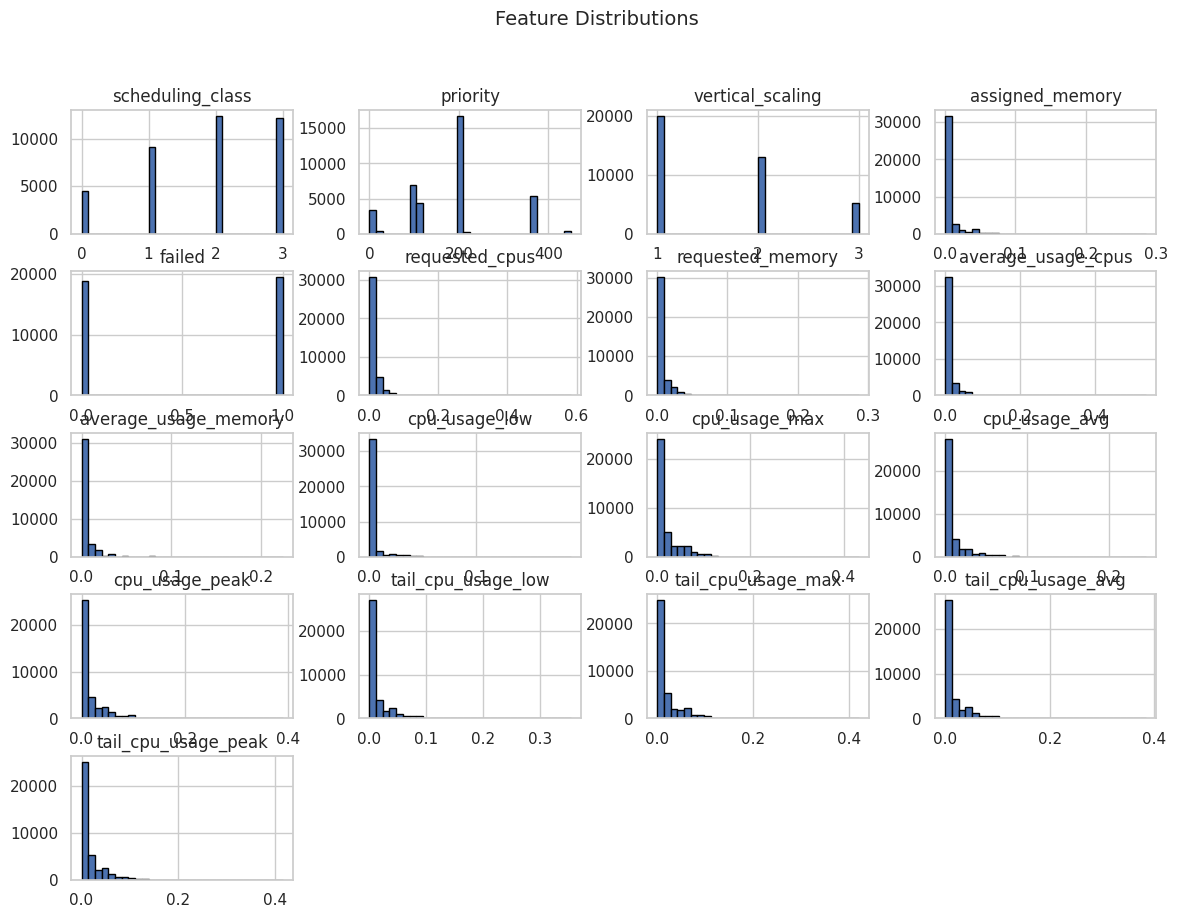

In [24]:
# HISTOGRAMS AND KDE PLOTS
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Plot distributions
fdf.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

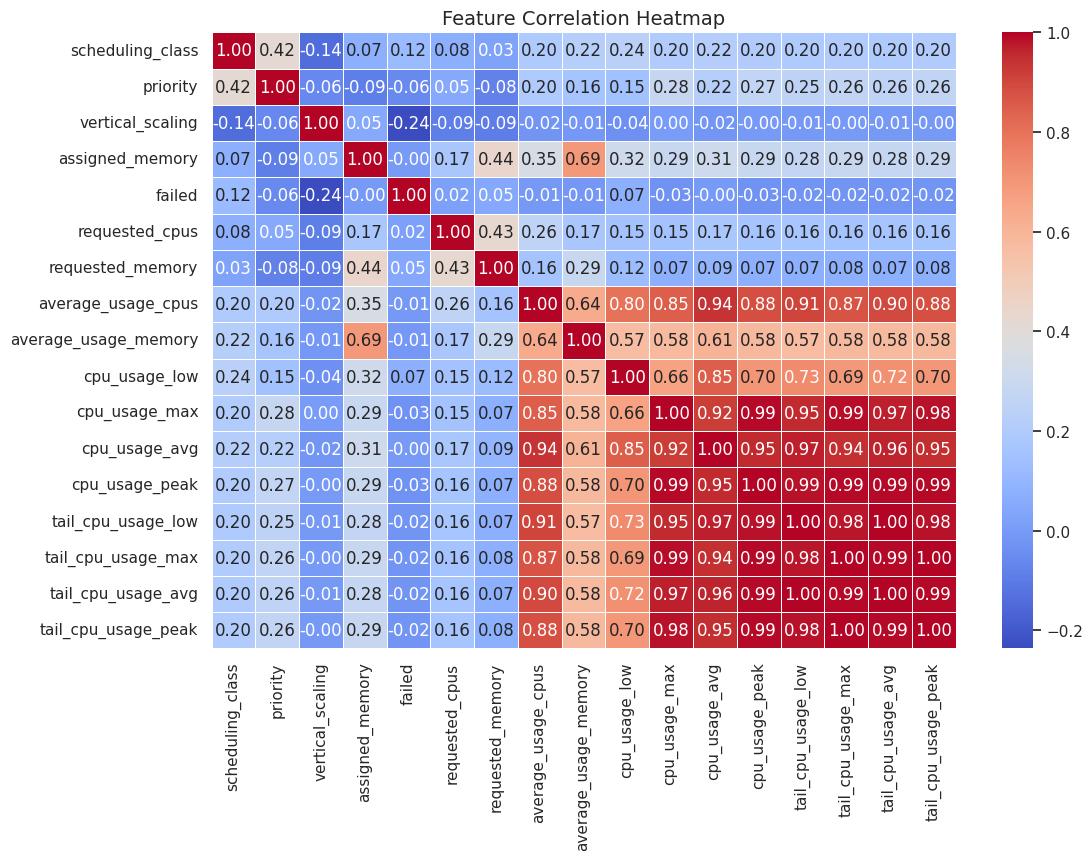

In [25]:
# CORRELATION MAP
plt.figure(figsize=(12, 8))
sns.heatmap(fdf.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

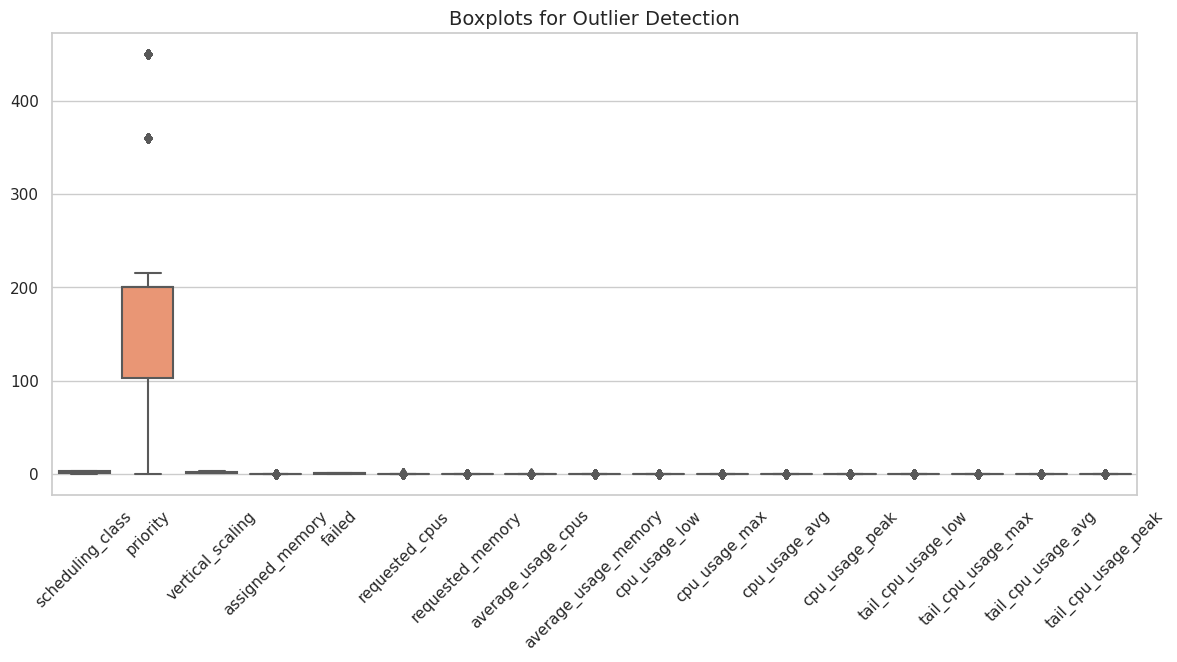

In [26]:
# BOX PLOTS - OUTLIER DETECTIONS
plt.figure(figsize=(14, 6))
sns.boxplot(data=fdf, palette="Set2")
plt.xticks(rotation=45)
plt.title("Boxplots for Outlier Detection", fontsize=14)
plt.show()

In [29]:
# feature_groups = [
#     ["priority", "requested_cpus", "requested_memory", "failed"],
#     ["cpu_usage_avg", "cpu_usage_max", "cpu_usage_peak", "failed"],
#     ["memory_usage_avg", "memory_usage_max", "memory_usage_peak", "failed"]
# ]

# for group in feature_groups:
#     sns.pairplot(fdf[group].sample(1000), diag_kind="kde", plot_kws={"alpha": 0.5})
#     plt.show()

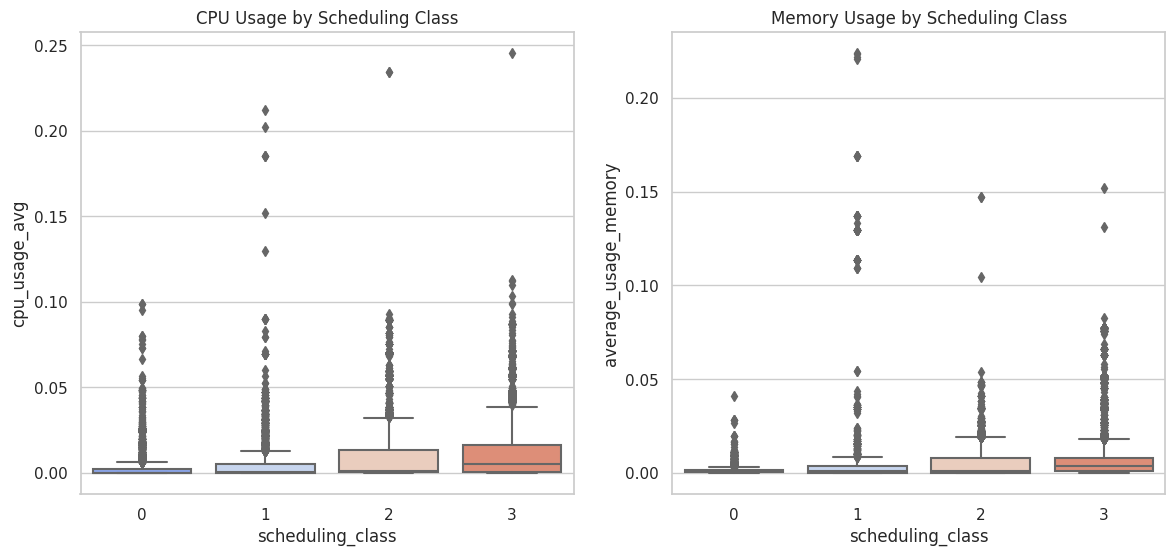

In [30]:
# CPU AND MEMORY USAGE TRENDS
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x="scheduling_class", y="cpu_usage_avg", data=fdf, ax=axes[0], palette="coolwarm")
axes[0].set_title("CPU Usage by Scheduling Class")

sns.boxplot(x="scheduling_class", y="average_usage_memory", data=fdf, ax=axes[1], palette="coolwarm")
axes[1].set_title("Memory Usage by Scheduling Class")

plt.show()

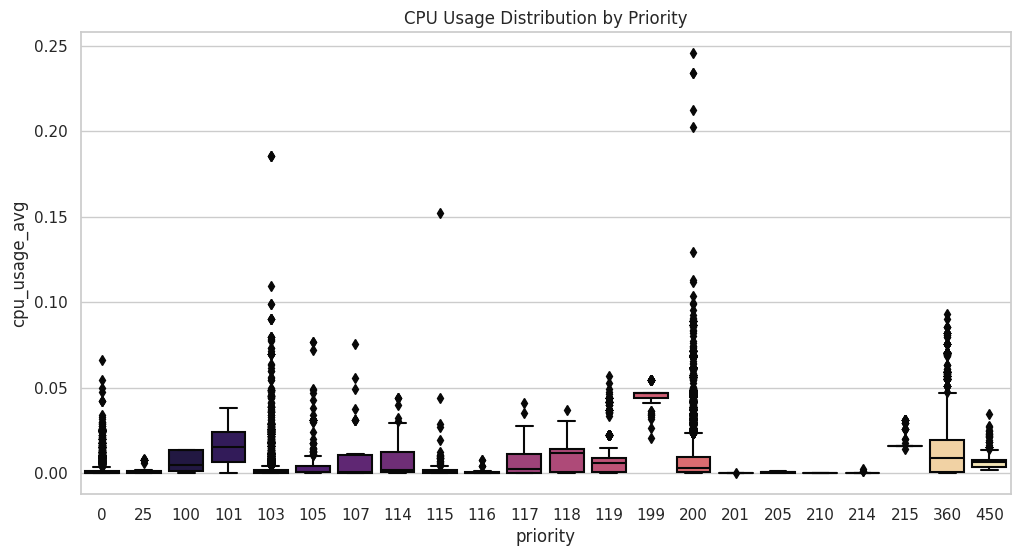

In [31]:
# CPU USAGE ACROSS DIFF. PRIORITY LEVELS
plt.figure(figsize=(12, 6))
sns.boxplot(x="priority", y="cpu_usage_avg", data=fdf, palette="magma")
plt.title("CPU Usage Distribution by Priority")
plt.show()

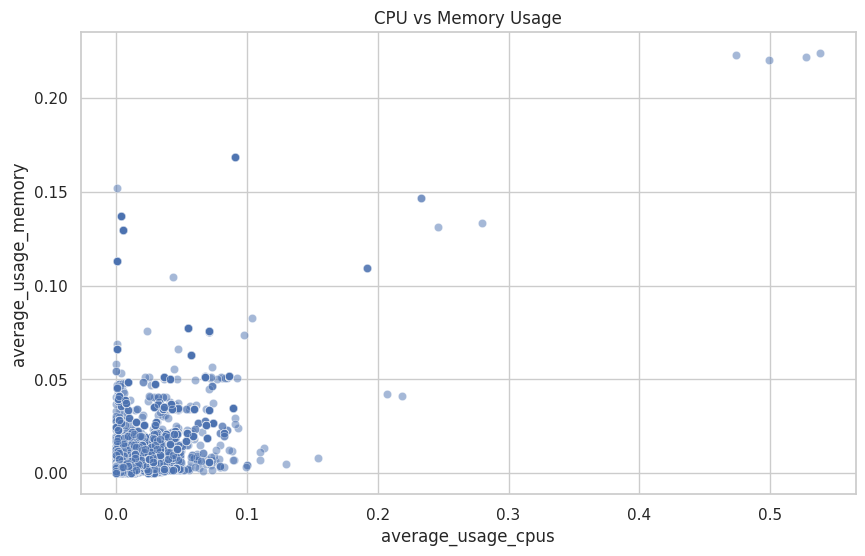

In [32]:
# SCATTER PLOT - CPU vs MEMORY
plt.figure(figsize=(10, 6))
sns.scatterplot(x="average_usage_cpus", y="average_usage_memory", data=fdf, alpha=0.5)
plt.title("CPU vs Memory Usage")
plt.show()

In [33]:
print(fdf.describe().T[["min", "max"]])

                      min         max
scheduling_class      0.0    3.000000
priority              0.0  450.000000
vertical_scaling      1.0    3.000000
assigned_memory       0.0    0.286133
failed                0.0    1.000000
requested_cpus        0.0    0.583008
requested_memory      0.0    0.286621
average_usage_cpus    0.0    0.538086
average_usage_memory  0.0    0.223877
cpu_usage_low         0.0    0.189453
cpu_usage_max         0.0    0.432129
cpu_usage_avg         0.0    0.245617
cpu_usage_peak        0.0    0.390625
tail_cpu_usage_low    0.0    0.353516
tail_cpu_usage_max    0.0    0.419434
tail_cpu_usage_avg    0.0    0.384766
tail_cpu_usage_peak   0.0    0.415332


In [34]:
# SELECTING FEATURES BY ANALYZING THE CORRELATION MAP

X_features = ['scheduling_class', 'priority', 'requested_cpus', 'requested_memory', 'assigned_memory']
y_features = ['average_usage_cpus', 'cpu_usage_peak', 'average_usage_memory', 'vertical_scaling']

In [35]:
print(fdf[X_features + y_features].dtypes)

scheduling_class          int64
priority                  int64
requested_cpus          float64
requested_memory        float64
assigned_memory         float64
average_usage_cpus      float64
cpu_usage_peak          float64
average_usage_memory    float64
vertical_scaling        float64
dtype: object


In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
fdf[X_features] = scaler.fit_transform(fdf[X_features])

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fdf[X_features], fdf[y_features], test_size=0.2, random_state=42)

In [43]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from tqdm import tqdm

In [65]:
param_grid = {
    'learning_rate': [0.01, 0.05, 1.0],  
    'max_depth': [3, 6, 8],  
    'n_estimators': [100, 200, 300],  
    'colsample_bytree': [0.8, 1.0],  
    'subsample': [0.8, 1.0],  
    'tree_method': ['gpu_hist'],
}

In [66]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, gpu_id=0)

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=3,  # 3-Fold Cross Validation
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Use all available CPU cores
)

In [67]:
import time

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

print(f"Time Taken: {end_time - start_time:.2f} seconds")

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:19:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Time Taken: 760.68 seconds


In [68]:
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8, 'tree_method': 'gpu_hist'}


In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"GPU-Based Model Test MSE: {mse:.4f}")
print(f"GPU-Based Model Test MAE: {mae:.4f}")


GPU-Based Model Test MSE: 0.0087
GPU-Based Model Test MAE: 0.0211


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:19:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


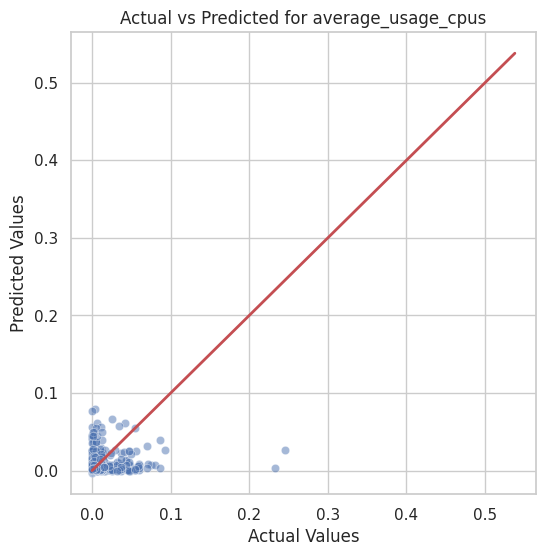

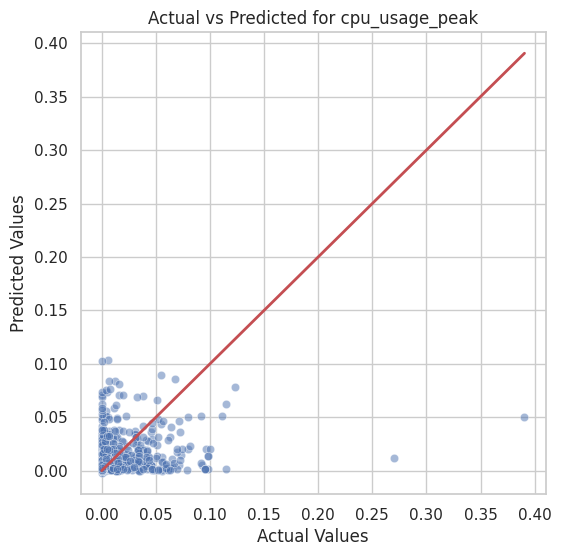

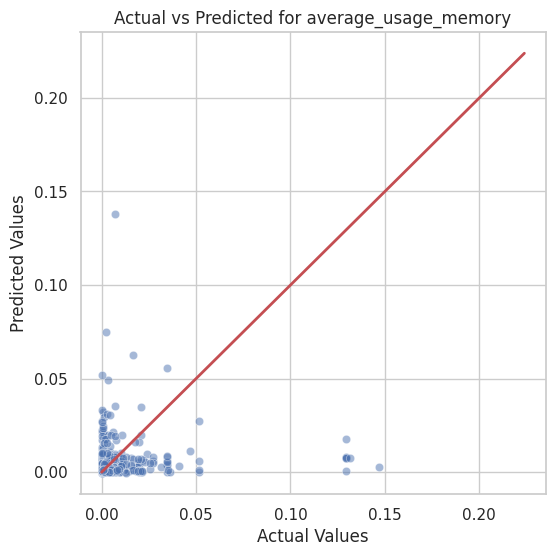

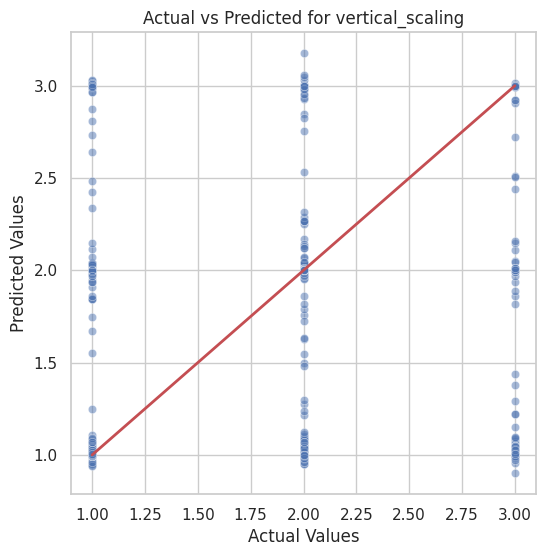

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

# Plot for each output variable
for col in y_test.columns:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test[col], y=y_pred_df[col], alpha=0.5)
    plt.plot([y_test[col].min(), y_test[col].max()], [y_test[col].min(), y_test[col].max()], 'r', lw=2)  # Ideal line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted for {col}")
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


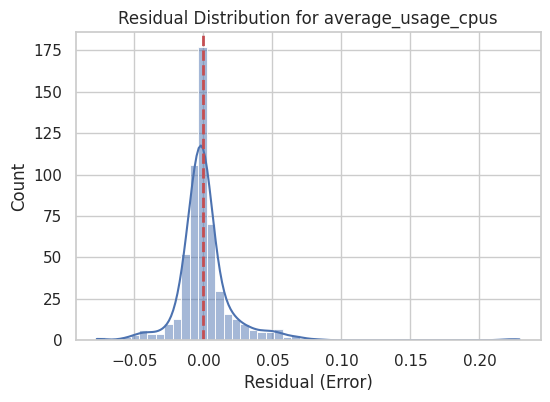

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


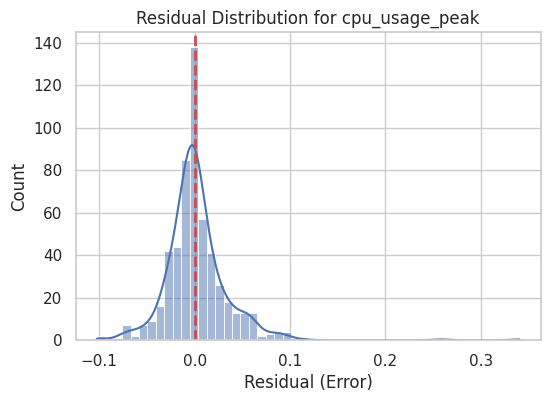

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


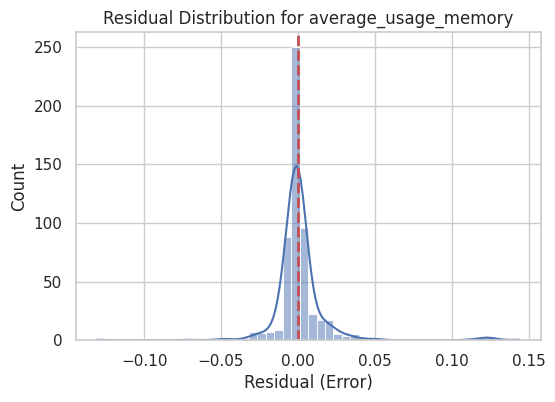

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


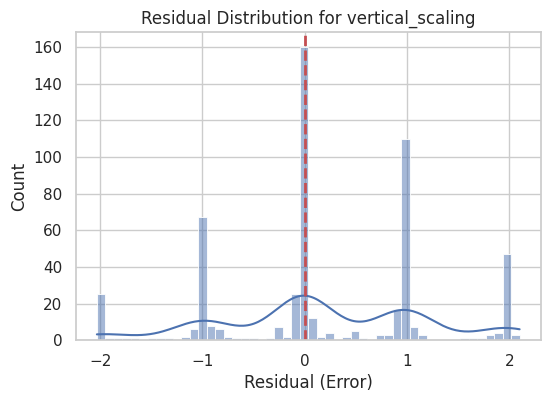

In [71]:
for col in y_test.columns:
    residuals = y_test[col] - y_pred_df[col]
    
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(0, color='r', linestyle='dashed', linewidth=2)  # Ideal zero error line
    plt.xlabel("Residual (Error)")
    plt.ylabel("Count")
    plt.title(f"Residual Distribution for {col}")
    plt.show()

In [72]:
# xgb.plot_importance(best_model, importance_type="weight", max_num_features=10)
# plt.show()

In [73]:
best_model.save_model("best_xgboost_gpu_resource_prediction.model")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:20:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


# INFERENCE

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd

# Load the trained models
model = xgb.Booster()
model.load_model("/kaggle/working/best_xgboost_gpu_resource_prediction.model")

In [75]:
def predict_resource_usage(input_data):
    """
    Inference function for predicting resource load.

    Parameters:
    input_data (dict): Dictionary with feature values. Example:
        {
            "scheduling_class": 2,
            "priority": 100,
            "requested_cpus": 0.25,
            "requested_memory": 0.1,
            "assigned_memory": 0.05
        }

    Returns:
    dict: Predictions for average_usage_cpus, cpu_usage_peak, average_usage_memory, vertical_scaling.
    """
    # Convert input dictionary to DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Ensure feature order matches training
    feature_order = ['scheduling_class', 'priority', 'requested_cpus', 'requested_memory', 'assigned_memory']
    input_df = input_df[feature_order]

    # Convert to DMatrix for XGBoost inference
    dmatrix_input = xgb.DMatrix(input_df)

    # Predict using the loaded model
    predictions = model.predict(dmatrix_input)

    output_features = ['average_usage_cpus', 'cpu_usage_peak', 'average_usage_memory', 'vertical_scaling']
    result = dict(zip(output_features, predictions.tolist()))

    return result

In [76]:
input_data = {
    "scheduling_class": 2,
    "priority": 100,
    "requested_cpus": 0.25,
    "requested_memory": 0.1,
    "assigned_memory": 0.05
}

output = predict_resource_usage(input_data)
print(output)

{'average_usage_cpus': [0.016376636922359467, 0.03373203054070473, 0.004714413546025753, 1.3817306756973267]}
